In [41]:
pip install numpy pandas scikit-learn tensorflow matplotlib ta requests

Note: you may need to restart the kernel to use updated packages.


In [42]:
pip install alpha-vantage

Note: you may need to restart the kernel to use updated packages.


In [43]:
"""
# Stock Price Prediction System with Alpha Vantage
This notebook implements an advanced stock price prediction system that:
1. Combines LSTM, Random Forest, and Gradient Boosting models
2. Includes technical indicators as features
3. Uses ensemble prediction
4. Evaluates model performance
"""

'\n# Stock Price Prediction System with Alpha Vantage\nThis notebook implements an advanced stock price prediction system that:\n1. Combines LSTM, Random Forest, and Gradient Boosting models\n2. Includes technical indicators as features\n3. Uses ensemble prediction\n4. Evaluates model performance\n'

In [44]:
import numpy as np
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime
import ta
import time
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [76]:
"""
## Stock Predictor Class
Defines the main class that handles data processing and predictions
"""

class StockPredictor:
    def __init__(self, stock_symbol, api_key, look_back=60, prediction_days=5, max_retries=3):
        self.stock_symbol = stock_symbol.upper()
        self.api_key = api_key
        self.look_back = look_back
        self.prediction_days = prediction_days
        self.max_retries = max_retries
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.data = None
        self.models = {}
        
    def get_stock_data(self):
        retries = 0
        while retries < self.max_retries:
            try:
                ts = TimeSeries(key=self.api_key, output_format='pandas')
                # Get daily data (Alpha Vantage provides adjusted close automatically)
                data, meta_data = ts.get_daily(symbol=self.stock_symbol, outputsize='full')
                data = data.rename(columns={
                    '1. open': 'Open',
                    '2. high': 'High',
                    '3. low': 'Low',
                    '4. close': 'Close',
                    '5. volume': 'Volume'
                })
                # Sort by date ascending (Alpha Vantage returns descending)
                data = data.sort_index()
                # Filter data from 2015 onwards
                data = data.loc['2015-01-01':datetime.today().strftime('%Y-%m-%d')]
                if data.empty:
                    raise ValueError(f"No data found for {self.stock_symbol}")
                self.data = data
                logging.info(f"Successfully downloaded data for {self.stock_symbol}")
                return True
            except Exception as e:
                retries += 1
                logging.warning(f"Attempt {retries} failed: {str(e)}")
                if retries == self.max_retries:
                    logging.error(f"Error fetching data for {self.stock_symbol} after {self.max_retries} attempts")
                    return False
                time.sleep(2 ** retries)  # Exponential backoff
                
    

    def add_technical_indicators(self):
        if self.data is None:
            return None
        df = self.data.copy()
        try:
            df['RSI'] = ta.momentum.RSIIndicator(df['Close']).rsi()
            df['MA20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
            df['MA50'] = ta.trend.SMAIndicator(df['Close'], window=50).sma_indicator()
            bb = ta.volatility.BollingerBands(df['Close'])
            df['BB_upper'] = bb.bollinger_hband()
            df['BB_middle'] = bb.bollinger_mavg()
            df['BB_lower'] = bb.bollinger_lband()
            df = df.dropna()
            self.data = df
            return df
        except Exception as e:
            logging.error(f"Error adding technical indicators: {str(e)}")
            return None

    def prepare_lstm_data(self):
        prices = self.data['Close'].values
        scaled_data = self.scaler.fit_transform(prices.reshape(-1, 1))
        
        X, y = [], []
        for i in range(self.look_back, len(scaled_data) - self.prediction_days):
            X.append(scaled_data[i-self.look_back:i])
            y.append(scaled_data[i:i+self.prediction_days]) 
        
        X, y = np.array(X), np.array(y)
        train_size = int(len(X) * 0.8)
        return (X[:train_size], y[:train_size], 
                X[train_size:], y[train_size:], scaled_data)

    def create_lstm_model(self):
        from tensorflow.keras.optimizers import Adam
        model = Sequential([
            LSTM(100, return_sequences=True, input_shape=(self.look_back, 1)),
            Dropout(0.3),
            LSTM(100),
            Dropout(0.3),
            Dense(50),
            Dense(self.prediction_days)
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        return model

    def train_models(self):
        if self.data is None:
            return None, None, None, None
            
        # Set random seed for reproducibility
        import tensorflow as tf
        import random
        np.random.seed(42)
        tf.random.set_seed(42)
        random.seed(42)

        # Updated feature set
        features = ['Close', 'RSI', 'MA20', 'MA50', 'BB_upper', 'BB_lower']
        X_lstm_train, y_lstm_train, X_lstm_test, y_lstm_test, scaled_data = self.prepare_lstm_data()
        
        self.models['lstm'] = self.create_lstm_model()
        self.models['lstm'].fit(X_lstm_train, y_lstm_train, epochs=50, 
                              batch_size=32, validation_split=0.1, verbose=1)
        
        # Prepare RF and GB data with separate scaling
        X = self.data[features].values
        y = self.data['Close'].shift(-self.prediction_days).values
        mask = ~np.isnan(y)
        X, y = X[mask], y[mask]
        
        total_samples = len(scaled_data) - self.look_back - self.prediction_days + 1
        train_size = int(total_samples * 0.8)
        
        # Scale features for RF/GB separately
        rf_gb_scaler = MinMaxScaler()
        X_scaled = rf_gb_scaler.fit_transform(X)
        
        X_train, X_test = X_scaled[:train_size], X_scaled[train_size:train_size + len(X_lstm_test)]
        y_train, y_test = y[:train_size], y[train_size:train_size + len(X_lstm_test)]
        
        self.models['rf'] = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
        self.models['rf'].fit(X_train, y_train)
        
        self.models['gb'] = GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
        self.models['gb'].fit(X_train, y_train)
        
        return X_lstm_test, y_lstm_test, X_test, y_test

    def predict(self, X_lstm_test, X_test):
        lstm_pred = self.models['lstm'].predict(X_lstm_test)
        rf_pred = self.models['rf'].predict(X_test)
        gb_pred = self.models['gb'].predict(X_test)
        
        lstm_pred_inv = self.scaler.inverse_transform(lstm_pred[:, -1].reshape(-1, 1))
        lstm_pred_inv = lstm_pred_inv.flatten()
        
        # Weighted ensemble with updated RMSE values
        lstm_rmse, rf_rmse, gb_rmse = 11.73, 72.60, 74.10  # New RMSE values
        total_inverse_rmse = (1/lstm_rmse) + (1/rf_rmse) + (1/gb_rmse)
        lstm_weight = (1/lstm_rmse) / total_inverse_rmse
        rf_weight = (1/rf_rmse) / total_inverse_rmse
        gb_weight = (1/gb_rmse) / total_inverse_rmse
        
        ensemble_pred = (lstm_weight * lstm_pred_inv + rf_weight * rf_pred + gb_weight * gb_pred)
        return ensemble_pred, lstm_pred_inv, rf_pred, gb_pred

2025-04-05 16:39:07,360 - INFO - Successfully downloaded data for MSFT


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0226 - val_loss: 6.2716e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 9.9463e-04 - val_loss: 8.8668e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 9.8158e-04 - val_loss: 5.9391e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 8.6027e-04 - val_loss: 0.0013
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 6.7784e-04 - val_loss: 5.9934e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 6.1796e-04 - val_loss: 0.0012
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 6.1763e-04 - val_loss: 5.1381e-04
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 5.3823e-04 - val_loss: 6.6879e-04
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 5.4474e-04 - val_loss: 6.5814e-04
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 4.6733e-04 - val_loss: 4.9387e-04
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 5.0429e-04 - val_loss: 4.7943e-0

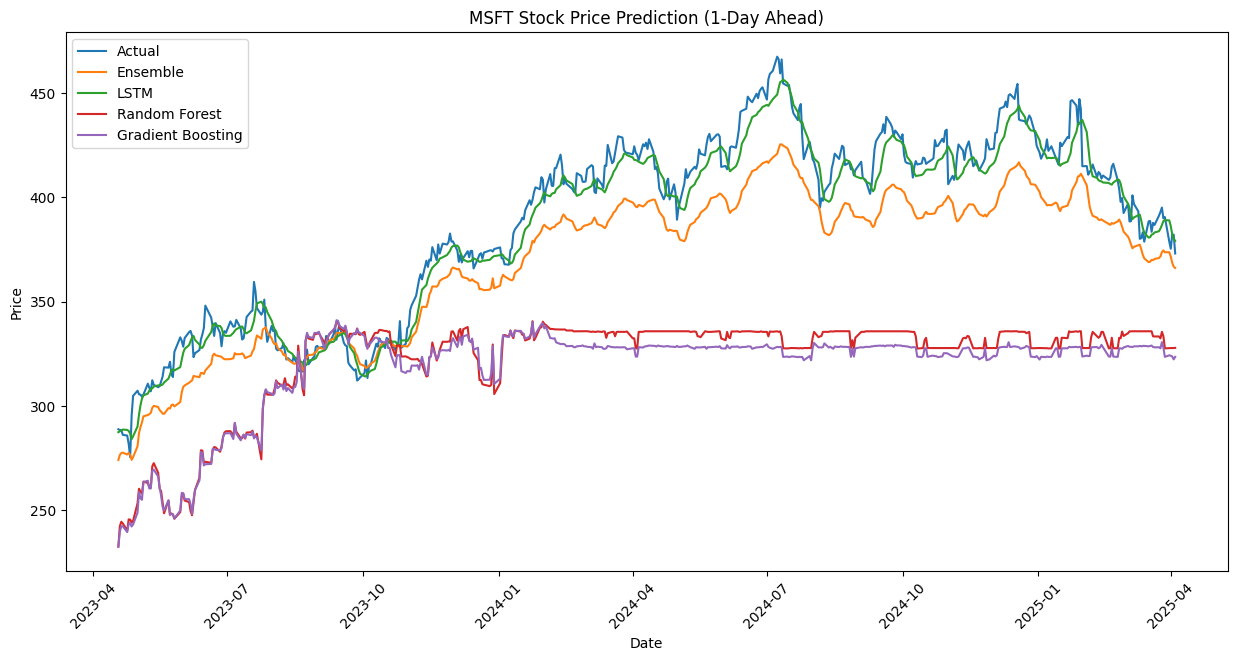

In [77]:
def main(stock_symbol, api_key):
    # Set prediction_days to 1 for better accuracy
    predictor = StockPredictor(stock_symbol, api_key, prediction_days=1)
    
    if not predictor.get_stock_data():
        return
    
    df = predictor.add_technical_indicators()
    if df is None:
        return
    
    X_lstm_test, y_lstm_test, X_test, y_test = predictor.train_models()  # Fixed typo: y JAMtest -> y_test
    if X_lstm_test is None:
        return
    
    ensemble_pred, lstm_pred, rf_pred, gb_pred = predictor.predict(X_lstm_test, X_test)
    y_test_inv = predictor.scaler.inverse_transform(y_lstm_test[:, -1].reshape(-1, 1)).flatten()
    
    for name, pred in [('Ensemble', ensemble_pred), ('LSTM', lstm_pred), 
                       ('RF', rf_pred), ('GB', gb_pred)]:
        rmse = np.sqrt(mean_squared_error(y_test_inv, pred))
        print(f'{name} RMSE: {rmse:.2f}')
    
    plt.figure(figsize=(15, 7))
    plt.plot(df.index[-len(y_test):], y_test_inv, label='Actual')
    plt.plot(df.index[-len(y_test):], ensemble_pred, label='Ensemble')
    plt.plot(df.index[-len(y_test):], lstm_pred, label='LSTM')
    plt.plot(df.index[-len(y_test):], rf_pred, label='Random Forest')
    plt.plot(df.index[-len(y_test):], gb_pred, label='Gradient Boosting')
    plt.title(f'{stock_symbol} Stock Price Prediction (1-Day Ahead)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# Replace 'YOUR_API_KEY' with your actual Alpha Vantage API key
api_key = 'YOUR_API_KEY'
main('MSFT', api_key)